# Data Mining Lab 3 Pipeline Assignment

**Medium articles** are used to disseminate knowledge and are written on a wide range of technical and non-technical topics. Users subscribe to different reading lists where reading lists represent either domains or certain topics. This naturally gives rise to a network structure where articles may belong to the same reading lists and hence are related to each other. Each article belongs to a certain topic. Automatically assigning articles to topics is very valuable for search applications. **The goal of this task is to classify articles by predicting their topics.**

A dataset of medium articles along with subscription lists and topic tags is provided. The task is to classify articles into tags (i.e., topics), leveraging the network structure arising from relations using the subscription lists. Specifically, two nodes are connected if they share at least one list.

**For this task you may only use the following libraries**: `numpy`, `pandas`, `matplotlib`, `networkx`, `gensim`.


In [1]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot
from gensim.models import Word2Vec

## Data loading

The data is provided in three files which can be found in the `data` directory:

- `articles.csv`: Contains the articles along with the subscription lists and some metadata.
- `test_data.csv`: Contains a subset of nodes (articles) along with their labels (topics) used for testing.
- `train_data.csv`: Contains the remaining nodes (articles) along with their labels (topics).

**Important**: There is no specific training data requried for this assignment, since the node embeddings (task 3) are trained on the entire graph. The nodes in `train_data.csv` must be used for the kNN classifier, i.e., the computed nearest neighbors for a test node may only be nodes from this file.

Let's use `pandas` to read these files:


In [2]:
articles = pd.read_csv(Path("data") / "articles.csv")
articles["node_id"] = articles.index
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(Path("data") / "test_data.csv")
train_data = pd.read_csv(Path("data") / "train_data.csv")

Note that we have assigned node IDs based on where each article is located in the file.

We can now inspect the individual data frames:


In [3]:
articles.head(2)

,article,title,subtitle,author,date,lists,node_id
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,[https://medium.com/@zemmali1990/list/aws-49f6...,0
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,[https://medium.com/@TomaszCieplak/list/graph-...,1


In [4]:
test_data.head(2)

,node_id,label
0,2291,artificial-intelligence
1,7292,artificial-intelligence


Next, let's create our graph. We'll create one node for each article and insert an edge between two articles if they share at least one subscription list:


In [5]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## Tasks

1. Familiarization: Analyze the graph. Compute and plot statistics such as the number of nodes, number of edges, number of neighbors of each node, and so on. Are there any isolated nodes (i.e., nodes that do not have a single neighbor)?
2. Compute spectral node embeddings.
3. Perform random walks on the graph to obtain a set of sequences of nodes. Use those sequences to compute node embeddings. Hint: You may use the Word2vec implementation of the gensim library for this task. By treating each node as a word, this method will give you node embeddings.
4. Implement a simple k-nearest neighbor classifier: For each node (medium article) in the test set, compute its nearest neighbors (based on the similarity of node embeddings). The classifier assigns a label (i.e., a topic) based on the topics of the nearest neighbors. Specifically, the predicted topic is simply the most common topic among the nearest neighbors. Compare both sets of node embeddings in terms of performance. Which one works better?


## 1. Familiarization

Number of nodes in the graph:  27718
Number of edges in the graph:  2014162
Average number of degrees per node:  72.67


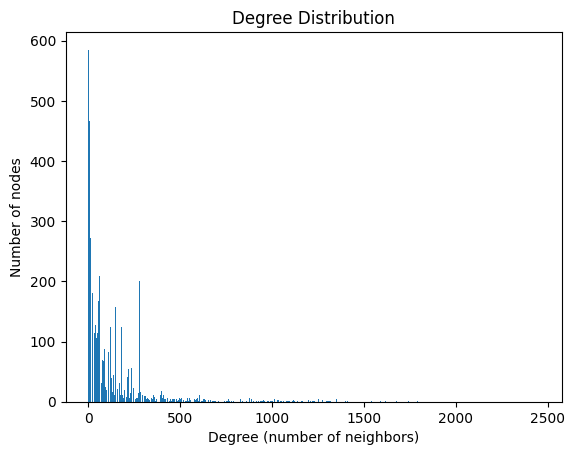

We can see that there are a lot of isolated nodes (nodes with 0 neighbours), namely 347
The node with the highest degree has 2452 neighbours. There are 2 nodes with many neighbours in the graph.


In [6]:
n = len(medium_graph.nodes)
m = len(medium_graph.edges)
print("Number of nodes in the graph: ", n)
print("Number of edges in the graph: ", m)

degree_view = medium_graph.degree
#print(degree_view)
degree_counts = {}
for _, degree in degree_view:
    if degree not in degree_counts:
        degree_counts[degree] = 1
    else:
        degree_counts[degree] += 1
#print(degree_counts)

degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

max_degree = max(degrees)

degree_dict = dict(degree_view)
number_of_isolated_nodes = list(degree_dict.values()).count(0)

degree_list = list(degree_view)
#print("degree_list", degree_list)
sorted_degree_list = sorted(degree_list, key=lambda x: x[1])

print("Average number of degrees per node: ", round(m/n, 2))

pyplot.bar(degrees, counts)
pyplot.xlabel('Degree (number of neighbors)')
pyplot.ylabel('Number of nodes')
pyplot.title('Degree Distribution')
pyplot.show()


#print("sorted list", sorted_degree_list)
print("We can see that there are a lot of isolated nodes (nodes with 0 neighbours), namely", number_of_isolated_nodes)



print("The node with the highest degree has", max_degree, "neighbours. There are", list(degree_dict.values()).count(max_degree), "nodes with many neighbours in the graph.")

## 2. Spectral node embeddings

The compute_spectral_embeddings function calculates the spectral embeddings for a connected graph. One thing to note is that sometimes the embedding of a node will have less dimensions than there are eigenvectors. This will cause the shape of the embedding to be smaller than other embeddings. We address this later by padding the embedding with 0's.

In [7]:
def compute_spectral_embeddings(graph: nx.Graph, dim: int, out_eigenvalues=None) -> np.ndarray:
    adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes))

    degrees = np.sum(adjacency_matrix, axis=1)
    degree_matrix = np.diag(degrees)

    laplacian_matrix = degree_matrix - adjacency_matrix

    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

    if (out_eigenvalues is not None): out_eigenvalues.append(eigenvalues)
    dim_eigenvectors = eigenvectors[:, :dim]
    result = dim_eigenvectors

    return result

Looking at the eigenvalues gives us valuable information on the embeddings, so we add an optional parameter to store the output of eigenvalues as well.

Let's split the graph into all the connected components, and call the compute_spectral_embedding function for each component.

In [8]:
spectral_embeddings = []
dim = 80
for component in nx.connected_components(medium_graph):
    subgraph = medium_graph.subgraph(component)
    emb = compute_spectral_embeddings(subgraph, dim)
    
    if emb.shape[1] < dim: # Pad with zeros if eigenvectors < dim
        padding = np.zeros((emb.shape[0], dim - emb.shape[1]))
        emb = np.hstack((emb, padding))

    spectral_embeddings.append(emb)

In [9]:
dim = 80
spectral_embedding = compute_spectral_embeddings(medium_graph, dim)

MemoryError: Unable to allocate 5.72 GiB for an array with shape (27718, 27718) and data type float64

We saw earlier that there are a lot of isolated nodes. The following diagram shows us the sizes of all the components. For better visualization purposes we got rid of the 2 largest components. These components had 24392 and 698 nodes.

198


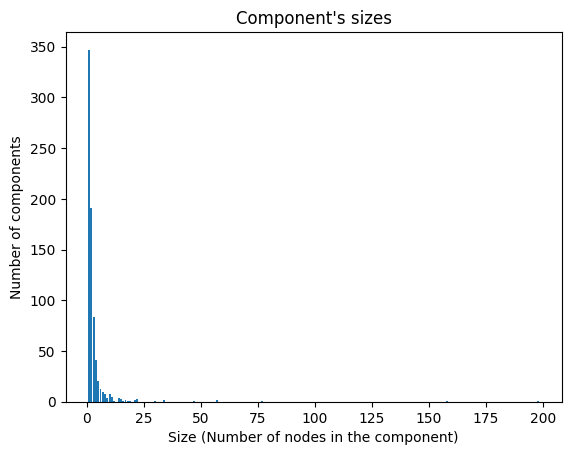

In [9]:
component_count = {}
maxi = 0
for emb in spectral_embeddings:
    size = emb.shape[0]
    if(size > 697):
        continue
    maxi = max(maxi, size)
    if size not in component_count:
        component_count[size] = 1
    else:
        component_count[size] += 1
#print(degree_counts)

print(maxi)

component_size = list(component_count.keys())
counts = list(component_count.values())

pyplot.bar(component_size, counts)
pyplot.xlabel('Size (Number of nodes in the component)')
pyplot.ylabel('Number of components')
pyplot.title('Component\'s sizes')
pyplot.show()

## 3. Random walks

When we create the random walks it is important that we handle the isolated nodes as well because our graph is disconnected. To handle them we will always make them walk back to themselves, this is a good idea here because isolated points are only similar to themselves. 

In [11]:
import random

def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
    length = len(graph.nodes)
    result = np.zeros((num_walks*length,walk_length))

    for i,node in enumerate(graph.nodes):
        for j in range(num_walks):
            result[num_walks*i+j,0] = node
            current_node = node
            for k in range(1, walk_length):
                neighbors = list(graph.neighbors(current_node))
                if not neighbors:
                    result[num_walks*i+j,k] = current_node
                    break
                current_node = random.choice(neighbors)
                result[num_walks*i+j,k] = current_node

    return result

In [12]:
num_walks = 10
walk_length = 20

walks = random_walks(medium_graph, num_walks, walk_length)

In [13]:
for i in range(10):
    print(walks[i * 10])

[    0. 15788.  3745. 22747. 12413. 19001. 18471. 19472. 12088. 12084.
   722.  1696.  4821.  9736. 12088.  8440.  8985.   863.  7336.  2450.]
[1.0000e+00 2.5421e+04 1.4045e+04 7.7650e+03 2.7424e+04 1.6843e+04
 2.6362e+04 1.5554e+04 1.2242e+04 1.3922e+04 1.0078e+04 1.1049e+04
 7.1800e+02 1.2034e+04 6.3150e+03 1.4890e+04 2.6813e+04 9.1790e+03
 1.1064e+04 8.4320e+03]
[2.0000e+00 2.1455e+04 1.1557e+04 2.1787e+04 2.5509e+04 9.3190e+03
 1.0779e+04 2.1824e+04 9.0800e+03 2.4107e+04 1.8565e+04 2.1760e+03
 1.0761e+04 1.1350e+03 1.4030e+04 6.7470e+03 4.6960e+03 1.0761e+04
 3.6020e+03 1.5679e+04]
[3.0000e+00 2.6120e+03 1.3825e+04 6.5620e+03 1.0170e+03 2.5608e+04
 2.6382e+04 6.7770e+03 1.9763e+04 1.3599e+04 2.6154e+04 1.3599e+04
 1.0145e+04 2.3046e+04 1.9746e+04 1.6890e+03 1.9455e+04 4.9410e+03
 3.4170e+03 7.7610e+03]
[4.0000e+00 1.1729e+04 2.3726e+04 7.0210e+03 1.1480e+04 2.6923e+04
 9.4970e+03 2.6856e+04 3.3670e+03 1.2429e+04 1.3938e+04 2.0229e+04
 8.0630e+03 1.4620e+04 6.1300e+03 1.4384e+04 7.8

Now let's use this function to compute node embeddings. 

In [38]:
def compute_node_embeddings(graph: nx.Graph, num_walks: int, walk_length: int, embedding_dim: int) -> Word2Vec:
    
    walks = random_walks(graph, num_walks, walk_length)
    
    # Convert node IDs to strings (Word2Vec expects strings)
    walks = [[str(node) for node in walk] for walk in walks]
    
    # Train Word2Vec model
    model = Word2Vec(
        sentences=walks,
        vector_size=embedding_dim,
        window=5,  # Context window size
        min_count=1,  # Minimum frequency for a node to be considered
        sg=1,  # Use Skip-Gram (sg=1), CBOW (sg=0)
        workers=4,  # Number of parallel threads
        epochs=10  # Number of training epochs
    )
    
    return model

In [41]:
num_walks = 10
walk_length = 20
embedding_dim = 100

node2vec_model = compute_node_embeddings(subgraph, num_walks, walk_length, embedding_dim)

Let's have a look at what a node embedding made from random walks looks like.

In [ ]:
node_id = "0"  # Node IDs are strings in the Word2Vec model
embedding = node2vec_model.wv[node_id]
print(f"Embedding for node {node_id}: {embedding}")

The function for the k-nearest neighbor classifier. We make sure to filter out nodes that are not in our training data. Note how distances are not calculated pairwise, but using the numpy library. This allows for paralellization and speeds up computation by using more CPU cores or GPU acceleration.

In [46]:
from heapq import nsmallest

train_node_ids = set(train_data['node_id'])

def k_nearest_neighbors(k, node, embedding):
    target_node = embedding[node]
    distances = np.linalg.norm(embedding - target_node, axis=1) #
    
    # Filter out neighbors that are not in the train_set
    filtered_distances = [(i,dist) for i,dist in enumerate(distances) if i in train_node_ids]

    # Sort distances based on the distance and get the indices of the k smallest distances
    closest_neighbors = nsmallest(k, filtered_distances, key=lambda x: x[1])
    closest_neighbors = [x[0] for x in closest_neighbors]
    labels = train_data[train_data['node_id'].isin(closest_neighbors)]  # Get labels of nearest neighbors
    common_label = labels['label'].mode()[0] # get [0] in case of tie in labels
    return common_label

Let's try to predict the labels of the test nodes using the spectral embedding with k arbitrarily chosen as 5.

In [ ]:
k = 20
spectral_result = np.zeros(len(test_data), dtype=object)
for i,row in enumerate(test_data.itertuples()):
    node = row.node_id
    prediction = k_nearest_neighbors(k, node, spectral_embedding)
    spectral_result[i] = (node, prediction)

In [ ]:
print(spectral_result[:10])

And do the same for the random walk embeddings.

In [ ]:
k = 20
random_walks_result = np.zeros(len(test_data), dtype=object)
for i,row in enumerate(test_data.itertuples()):
    node = row.node_id
    prediction = k_nearest_neighbors(k, node, node2vec_model.wv.vectors) # Get the underling ndarray of the node2vec_model
    random_walks_result[i] = (node, prediction)


In [ ]:
print(random_walks_result[:10])

Now let's analyze the performance of the embeddings.

In [ ]:
spectral_correct = sum((list(map(lambda x: x[1], spectral_result)) == test_data['label']))
random_walk_correct = sum((list(map(lambda x: x[1], random_walks_result)) == test_data['label']))

total = test_data.shape[0]

spectral_ratio = round(100*spectral_correct/total,2)
random_walk_ratio = round(100*random_walk_correct/total,2)

print('Spectral Ratio: ', spectral_ratio,'%', sep='')
print('Random Walk Ratio: ', random_walk_ratio,'%', sep='')